In [1]:
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

2.9.2


Declare constants

In [2]:
DATASET_DIR= "./data/tomato"
EPOCHS = 20
BATCH_SIZE = 32
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
IMAGE_CHANNELS = 3
IMAGE_SHAPE=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)
NUM_CLASSES=10

Load Dataset

In [3]:
# from keras.preprocessing.image import ImageDataGenerator

# train_datagen = ImageDataGenerator(
#   # shear_range=0.3,
#   # zoom_range=0.3,
#   # horizontal_flip=True,
#   # vertical_flip=True,
#   # rotation_range=180,
#   # fill_mode='nearest',
#   validation_split=0.25,
#   seed=69,
# )

# train_ds = train_datagen.flow_from_directory(
#   F"{DATASET_DIR}",
#   # batch_size=BATCH_SIZE,
#   target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
#   # class_mode='categorical',
#   subset='training'
# )

# val_datagen = ImageDataGenerator()

# val_ds = train_datagen.flow_from_directory(
#   F"{DATASET_DIR}",
#   # batch_size=BATCH_SIZE,
#   target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
#   # class_mode='categorical',
#   subset='validation'
# )

train_ds = keras.utils.image_dataset_from_directory(
  F"{DATASET_DIR}/train",
  # validation_split=0.2,
  # subset="training",
  seed=123,
  image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
  batch_size=BATCH_SIZE,
)

val_ds = keras.utils.image_dataset_from_directory(
  F"{DATASET_DIR}/valid",
  # validation_split=0.2,
  # subset="validation",
  seed=456,
  image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
  batch_size=BATCH_SIZE,
)

Found 10000 files belonging to 10 classes.
Found 1000 files belonging to 10 classes.


preview data

['Bacterial Spot', 'Early Blight', 'Healthy', 'Late Blight', 'Leaf Mold', 'Mosaic Virus', 'Septoria Leaf Spot', 'Target Spot', 'Two Spotted Spider Mite', 'Yellow Leaf Curl Virus']


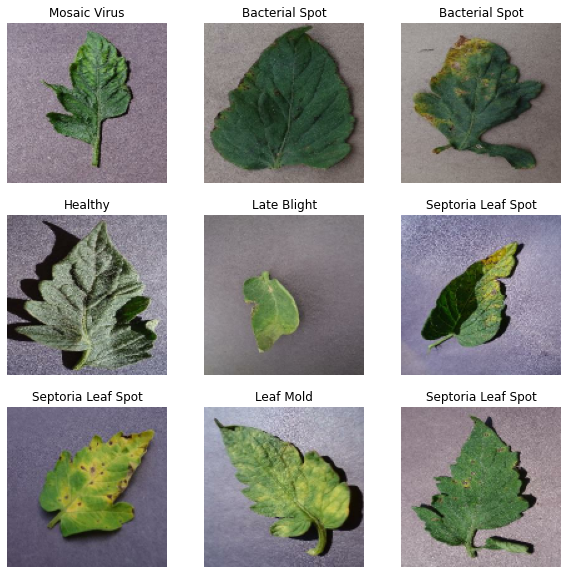

In [4]:
class_names = train_ds.class_names
print(class_names)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# for image_batch, labels_batch in train_ds:
#   print(image_batch.shape)
#   print(labels_batch.shape)
#   break

Data Augmentation pipeline

In [5]:
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal_and_vertical"),
    keras.layers.RandomRotation(0.2),
    keras.layers.RandomTranslation(0.2, 0.2),
    keras.layers.RandomZoom(0.2),
    keras.layers.RandomBrightness(0.4),
    keras.layers.RandomContrast(0.4),
])

Image Preprocessing pipeline

In [6]:
preprocessing = keras.Sequential([
    keras.layers.Reshape(IMAGE_SHAPE),
    keras.layers.Rescaling(1./255),
])

Prefetch Data and setup augmentation

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)

<ParallelMapDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

Build The CNN

In [8]:
model = keras.models.Sequential([
    keras.layers.Input(shape=(128, 128, 3)),

    preprocessing,
    # data_augmentation,

    keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
    keras.layers.MaxPooling2D(),

    keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
    keras.layers.MaxPooling2D(4),

    keras.layers.Conv2D(128, 3, padding="same", activation="relu"),
    # keras.layers.MaxPooling2D(),

    keras.layers.Dropout(0.2),

    keras.layers.GlobalAveragePooling2D(),

    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.2),

    keras.layers.Dense(NUM_CLASSES, activation="softmax")
])


model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

model.summary(
    expand_nested=True,
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 128, 128, 3)       0         
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| reshape (Reshape)         (None, 128, 128, 3)       0         |
|                                                               |
| rescaling (Rescaling)     (None, 128, 128, 3)       0         |
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                      

Training

In [9]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    # steps_per_epoch=train_ds.samples/train_ds.batch_size,
    # batch_size=BATCH_SIZE,
    # validation_steps=validation_ds.samples/validation_ds.batch_size
)

Epoch 1/20
313/313 [==============================] - 21s 65ms/step - loss: 1.9841 - sparse_categorical_accuracy: 0.2434 - val_loss: 1.5407 - val_sparse_categorical_accuracy: 0.3830
Epoch 2/20
313/313 [==============================] - 19s 62ms/step - loss: 1.3099 - sparse_categorical_accuracy: 0.5202 - val_loss: 1.1690 - val_sparse_categorical_accuracy: 0.5620
Epoch 3/20
313/313 [==============================] - 19s 61ms/step - loss: 0.9874 - sparse_categorical_accuracy: 0.6425 - val_loss: 0.9707 - val_sparse_categorical_accuracy: 0.6560
Epoch 4/20
313/313 [==============================] - 19s 60ms/step - loss: 0.7622 - sparse_categorical_accuracy: 0.7295 - val_loss: 0.6078 - val_sparse_categorical_accuracy: 0.7920
Epoch 5/20
313/313 [==============================] - 19s 60ms/step - loss: 0.6010 - sparse_categorical_accuracy: 0.7872 - val_loss: 0.6434 - val_sparse_categorical_accuracy: 0.7870
Epoch 6/20
313/313 [==============================] - 20s 63ms/step - loss: 0.5158 - spars

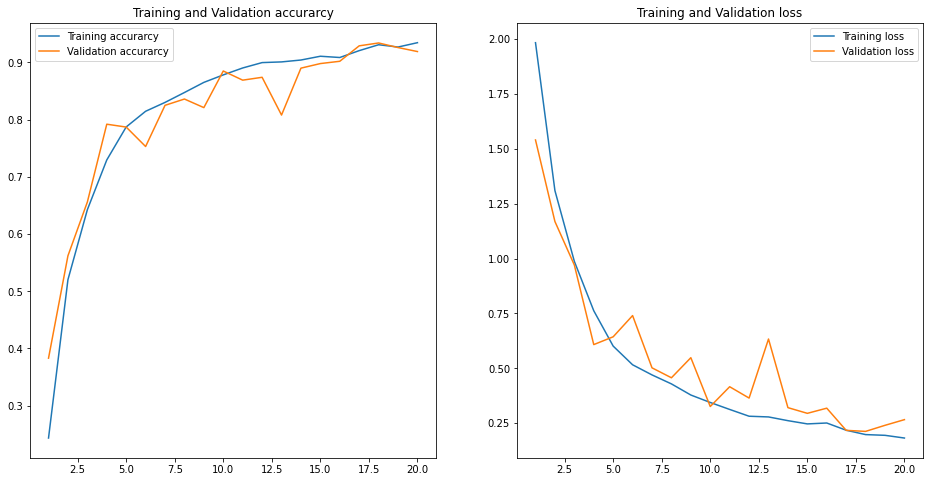

In [10]:
from matplotlib import pyplot as plt

acc = history.history["sparse_categorical_accuracy"]
val_acc = history.history["val_sparse_categorical_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)

# Train and validation accuracy
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
# plt.ylim((0, 1))
plt.plot(epochs, acc, label="Training accurarcy")
plt.plot(epochs, val_acc, label="Validation accurarcy")
plt.title("Training and Validation accurarcy")
plt.legend()

# Train and validation loss
plt.subplot(1, 2, 2)

plt.plot(epochs, loss, label="Training loss")
plt.plot(epochs, val_loss, label="Validation loss")
plt.title("Training and Validation loss")
plt.legend()
plt.show()

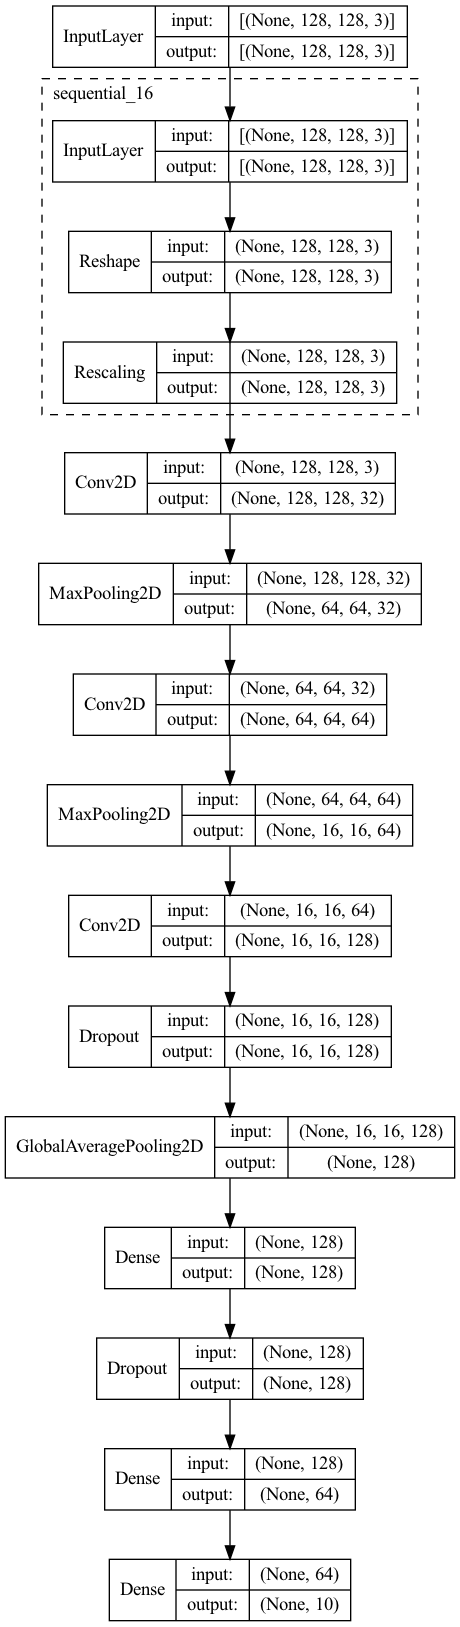

In [38]:
dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(
    model,
    to_file=dot_img_file,
    show_shapes=True,
    show_layer_names=False,
    expand_nested=True
)

Prediction

In [ ]:
# print(train_ds.class_indices)

In [ ]:
# import numpy as np

# img = keras.utils.load_img(
#   f"{DATASET_DIR}/test/Leaf smut/smut-_0_2488.jpg",
#   # target_size=(IMAGE_HEIGHT, IMAGE_WIDTH)
# )

# img_array = tf.keras.utils.img_to_array(img)
# img_array = tf.expand_dims(img_array, 0)

# predictions = model.predict(img_array)

# for prediction in predictions:
#   score = tf.nn.softmax(prediction)
#   # class_names = train_ds.class_names
#   print(
#       100*score
#   )

In [ ]:
# def predict(type):
#   img = keras.utils.load_img(
#     f"{DATASET_DIR}/test/Leaf smut/smut-_0_2488.jpg",
#     # target_size=(128, 128)
#   )

#   img_array = tf.keras.utils.img_to_array(img)
#   img_array = tf.expand_dims(img_array, 0)

#   predictions = model.predict(img_array)
#   score = tf.nn.softmax(predictions[0])


#   path = src
#   img_matrix = convert_image_to_array(path)
#   toBePredictedImage = np.expand_dims(img_matrix, axis=0)
  
#   result = model.predict(toBePredictedImage)
#   predictedClass = [np.argmax(element) for element in result]
#   image_folder = path[9:10]
#   boolResult = False
#   if str(image_folder) == str(predictedClass[0]):
#       boolResult = True
#   # print(f"\nPredicted value for {path} --- Predicted Class {predictedClass} --- Result {result} --- Correct???? {boolResult}")
#   return boolResult